# T3: Node2vec节点嵌入

**任务描述：** 利用Node2vec计算每个节点的embedding值。

**要求输出：**
1. 每个节点的embedding值列表（CSV文件）
2. 随机挑选10个node pair，对比他们在embedding上的相似度和在betweenness centrality上的相似度（使用Jaccard similarity）


In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from gensim.models import Word2Vec
import random
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings('ignore')

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False


## 1. 加载数据并构建图


In [26]:
# 读取边列表数据
df = pd.read_csv('Node2vec_Dataset.csv')
print(f"数据形状: {df.shape}")
print(f"\n前10条边:")
print(df.head(10))

# 创建无向图
G = nx.Graph()
edges = [(row['node_1'], row['node_2']) for _, row in df.iterrows()]
G.add_edges_from(edges)

print(f"\n图的基本信息:")
print(f"  节点数: {G.number_of_nodes()}")
print(f"  边数: {G.number_of_edges()}")
print(f"  是否为连通图: {nx.is_connected(G)}")


数据形状: (27806, 2)

前10条边:
   node_1  node_2
0       0     747
1       1    4257
2       1    2194
3       1     580
4       1    6478
5       1    1222
6       1    5735
7       1    7146
8       1    2204
9       1     126

图的基本信息:
  节点数: 7624
  边数: 27806
  是否为连通图: True


## 2. 实现Node2vec算法


In [27]:
class Node2Vec:
    """
    Node2vec算法实现
    使用随机游走生成节点序列，然后使用Word2Vec学习节点嵌入
    """
    
    def __init__(self, graph, walk_length=80, num_walks=10, p=1, q=1):
        """
        参数:
            graph: NetworkX图对象
            walk_length: 每次随机游走的长度
            num_walks: 每个节点开始的游走次数
            p: 返回参数（控制回到上一个节点的概率）
            q: 出入参数（控制探索新节点的概率）
        """
        self.graph = graph
        self.walk_length = walk_length
        self.num_walks = num_walks
        self.p = p
        self.q = q
        self.walks = []
        
    def _get_alias_edge(self, src, dst):
        """获取边的alias采样表（用于biased random walk）"""
        unnormalized_probs = []
        for dst_nbr in sorted(self.graph.neighbors(dst)):
            if dst_nbr == src:
                unnormalized_probs.append(1.0 / self.p)
            elif self.graph.has_edge(dst_nbr, src):
                unnormalized_probs.append(1.0)
            else:
                unnormalized_probs.append(1.0 / self.q)
        
        norm_const = sum(unnormalized_probs)
        normalized_probs = [float(u_prob) / norm_const for u_prob in unnormalized_probs]
        
        return self._alias_setup(normalized_probs)
    
    def _alias_setup(self, probs):
        """设置alias采样表"""
        K = len(probs)
        q = np.zeros(K)
        J = np.zeros(K, dtype=np.int32)
        
        smaller = []
        larger = []
        for kk, prob in enumerate(probs):
            q[kk] = K * prob
            if q[kk] < 1.0:
                smaller.append(kk)
            else:
                larger.append(kk)
        
        while len(smaller) > 0 and len(larger) > 0:
            small = smaller.pop()
            large = larger.pop()
            
            J[small] = large
            q[large] = q[large] - (1.0 - q[small])
            
            if q[large] < 1.0:
                smaller.append(large)
            else:
                larger.append(large)
        
        return J, q
    
    def _alias_draw(self, J, q):
        """从alias表中采样"""
        K = len(J)
        kk = int(np.floor(np.random.rand() * K))
        if np.random.rand() < q[kk]:
            return kk
        else:
            return J[kk]
    
    def node2vec_walk(self, start_node):
        """从起始节点开始biased random walk"""
        walk = [start_node]
        
        while len(walk) < self.walk_length:
            cur = walk[-1]
            cur_nbrs = sorted(self.graph.neighbors(cur))
            if len(cur_nbrs) > 0:
                if len(walk) == 1:
                    # 第一步，均匀采样
                    walk.append(cur_nbrs[random.randint(0, len(cur_nbrs) - 1)])
                else:
                    # 后续步骤，使用biased random walk
                    prev = walk[-2]
                    J, q = self._get_alias_edge(prev, cur)
                    next_node = cur_nbrs[self._alias_draw(J, q)]
                    walk.append(next_node)
            else:
                break
        
        return [str(node) for node in walk]
    
    def generate_walks(self):
        """为所有节点生成随机游走序列"""
        print("生成随机游走序列...")
        nodes = list(self.graph.nodes())
        
        for walk_iter in range(self.num_walks):
            print(f"  游走轮次 {walk_iter + 1}/{self.num_walks}")
            random.shuffle(nodes)
            for node in nodes:
                walk = self.node2vec_walk(node)
                self.walks.append(walk)
        
        print(f"生成了 {len(self.walks)} 条游走序列")
        return self.walks

print("Node2vec类已定义")


Node2vec类已定义


In [28]:
# 创建Node2vec对象并生成随机游走序列
node2vec = Node2Vec(G, walk_length=80, num_walks=10, p=1, q=1)
walks = node2vec.generate_walks()

# 显示一些游走序列示例
print("\n随机游走序列示例:")
for i in range(min(3, len(walks))):
    print(f"  序列 {i+1}: {walks[i][:20]}...")


生成随机游走序列...
  游走轮次 1/10
  游走轮次 2/10
  游走轮次 3/10
  游走轮次 4/10
  游走轮次 5/10
  游走轮次 6/10
  游走轮次 7/10
  游走轮次 8/10
  游走轮次 9/10
  游走轮次 10/10
生成了 76240 条游走序列

随机游走序列示例:
  序列 1: ['4064', '469', '3198', '4908', '1613', '1389', '3198', '469', '5222', '1389', '1613', '3614', '4267', '2238', '3597', '1234', '3597', '4527', '502', '6519']...
  序列 2: ['1062', '2926', '3418', '1376', '3073', '4939', '2498', '1428', '2498', '5274', '4123', '4515', '4123', '5411', '3450', '7199', '1792', '6207', '3822', '1040']...
  序列 3: ['4764', '4341', '452', '5516', '2653', '3552', '2653', '5516', '5816', '2992', '1814', '2992', '452', '1164', '5516', '2854', '2888', '2854', '2073', '4669']...


## 4. 使用Word2Vec学习节点嵌入


In [29]:
# 使用Word2Vec训练节点嵌入模型
print("训练Word2Vec模型...")
model = Word2Vec(
    walks,
    vector_size=128,      # 嵌入维度
    window=10,            # 上下文窗口大小
    min_count=1,          # 最小词频
    sg=1,                 # Skip-gram模型
    workers=4,            # 并行线程数
    epochs=5              # 训练轮数
)

print("训练完成！")
print(f"词汇表大小: {len(model.wv)}")
print(f"嵌入维度: {model.wv.vector_size}")

# 获取所有节点的嵌入向量
node_embeddings = {}
for node in G.nodes():
    node_embeddings[int(node)] = model.wv[str(node)]

print(f"\n节点嵌入字典大小: {len(node_embeddings)}")
print(f"嵌入向量示例 (节点0): {node_embeddings[0][:5]}...")


训练Word2Vec模型...


Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_fl

训练完成！
词汇表大小: 7624
嵌入维度: 128

节点嵌入字典大小: 7624
嵌入向量示例 (节点0): [-0.13162066  0.0137785   0.5407518  -0.17835087  0.5378164 ]...


## 5. 保存节点embedding到CSV文件


In [30]:
# 将所有节点的embedding保存到CSV文件
nodes_list = sorted(node_embeddings.keys())
embedding_data = []

for node in nodes_list:
    embedding_vector = node_embeddings[node]
    row = {'node_id': node}
    for i, val in enumerate(embedding_vector):
        row[f'dim_{i}'] = val
    embedding_data.append(row)

# 创建DataFrame并保存
embedding_df = pd.DataFrame(embedding_data)
output_file = 'node_embeddings.csv'
embedding_df.to_csv(output_file, index=False)

print(f"节点embedding已保存到 {output_file}")
print(f"文件包含 {len(embedding_df)} 个节点，每个节点 {len(embedding_vector)} 维embedding")
print(f"\n前5行数据预览:")
print(embedding_df.head())


节点embedding已保存到 node_embeddings.csv
文件包含 7624 个节点，每个节点 128 维embedding

前5行数据预览:
   node_id     dim_0     dim_1     dim_2     dim_3     dim_4     dim_5  \
0        0 -0.131621  0.013779  0.540752 -0.178351  0.537816 -0.222445   
1        1  0.098844 -0.168114  0.444864  0.162875  0.513603  0.212203   
2        2  0.746004  0.492548  0.334333  0.456922  0.206612 -0.647117   
3        3 -0.079318  0.563622  0.574308  0.291520  0.138262 -0.321974   
4        4 -0.620296  0.409881  0.000364  0.971616  0.184122  0.088650   

      dim_6     dim_7     dim_8  ...   dim_118   dim_119   dim_120   dim_121  \
0  0.458831 -0.032882  0.048487  ...  0.204821  0.211900 -0.356210 -0.165459   
1  0.516254 -0.267506  0.002877  ...  0.035825 -0.146333 -0.655152 -0.229431   
2 -0.330553 -0.309250  0.267297  ...  0.851787 -0.068305 -0.170248 -0.610584   
3  0.230079 -0.122911  0.262662  ...  0.192774 -0.064753 -0.222098 -0.459608   
4  0.043294 -0.030870 -0.276054  ...  0.727234  0.767159 -0.298349  0.03741

## 6. 计算betweenness centrality


In [31]:
# 计算所有节点的betweenness centrality
print("计算betweenness centrality（这可能需要一些时间）...")
betweenness = nx.betweenness_centrality(G)
print("计算完成！")

# 显示一些统计信息
betweenness_values = list(betweenness.values())
print(f"\nBetweenness Centrality统计:")
print(f"  平均值: {np.mean(betweenness_values):.6f}")
print(f"  最大值: {max(betweenness_values):.6f}")
print(f"  最小值: {min(betweenness_values):.6f}")

# 找出betweenness最高的节点
top_betweenness = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[:5]
print("\nBetweenness Centrality最高的5个节点:")
for node, bc in top_betweenness:
    print(f"  节点 {node}: {bc:.6f}")


计算betweenness centrality（这可能需要一些时间）...
计算完成！

Betweenness Centrality统计:
  平均值: 0.000555
  最大值: 0.089931
  最小值: 0.000000

Betweenness Centrality最高的5个节点:
  节点 7199: 0.089931
  节点 7237: 0.085589
  节点 2854: 0.077563
  节点 4356: 0.067250
  节点 6101: 0.051805


## 7. 随机选择10个节点对并比较相似度


随机选择的10个节点对:
  节点对 1: (6329, 4426)
  节点对 2: (20, 5258)
  节点对 3: (5319, 2524)
  节点对 4: (4279, 2387)
  节点对 5: (2423, 5644)
  节点对 6: (4241, 2461)
  节点对 7: (4812, 4258)
  节点对 8: (1327, 2769)
  节点对 9: (792, 3418)
  节点对 10: (7287, 1149)

计算embedding相似度...
计算betweenness centrality相似度（使用邻居集合的Jaccard相似度）...

节点对相似度对比结果:
   node_pair  embedding_similarity  bc_jaccard_similarity  betweenness_node1  betweenness_node2
(6329, 4426)              0.327357                    0.0           0.000055           0.003086
  (20, 5258)              0.205177                    0.0           0.000603           0.000120
(5319, 2524)              0.172813                    0.0           0.002025           0.000198
(4279, 2387)              0.273827                    0.0           0.000027           0.000762
(2423, 5644)              0.158943                    0.0           0.000000           0.000026
(4241, 2461)              0.225201                    0.0           0.000381           0.000000
(4812, 4258)   

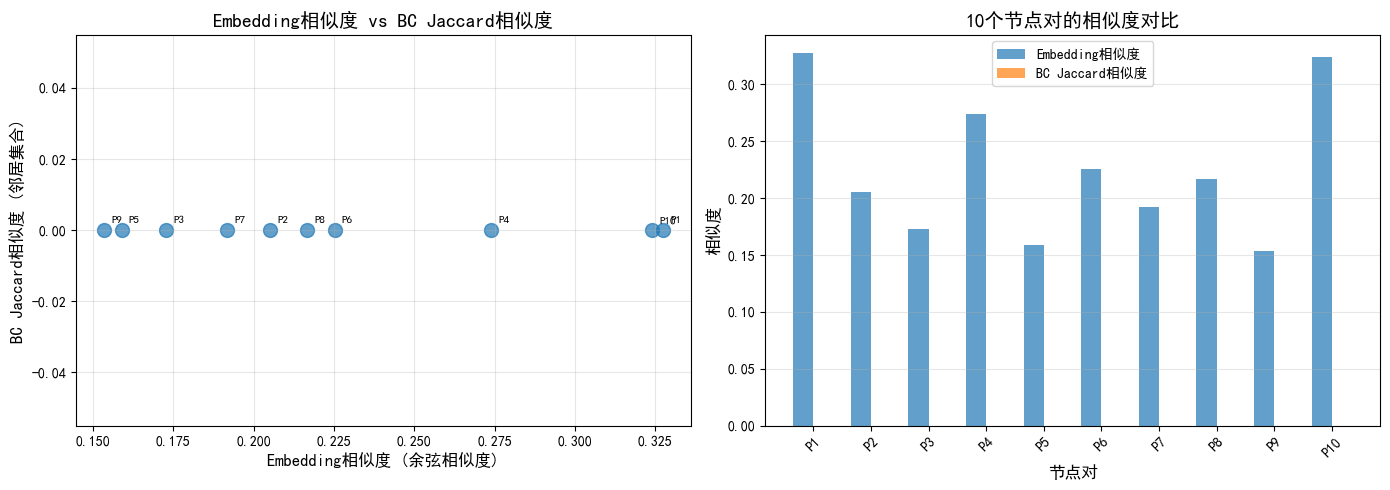


结果已保存到 node_pair_similarity_comparison.csv


In [32]:
def jaccard_similarity(set1, set2):
    """计算两个集合的Jaccard相似度"""
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    if union == 0:
        return 0.0
    return intersection / union

# 随机选择10个节点对
np.random.seed(42)
random.seed(42)
all_nodes = list(G.nodes())
selected_pairs = []

for _ in range(10):
    node1, node2 = random.sample(all_nodes, 2)
    selected_pairs.append((node1, node2))

print("随机选择的10个节点对:")
for i, (node1, node2) in enumerate(selected_pairs, 1):
    print(f"  节点对 {i}: ({node1}, {node2})")

# 计算embedding相似度（使用余弦相似度）
print("\n计算embedding相似度...")
embedding_similarities = []

for node1, node2 in selected_pairs:
    if node1 in node_embeddings and node2 in node_embeddings:
        emb1 = node_embeddings[node1].reshape(1, -1)
        emb2 = node_embeddings[node2].reshape(1, -1)
        cos_sim = cosine_similarity(emb1, emb2)[0][0]
        embedding_similarities.append(cos_sim)
    else:
        embedding_similarities.append(0.0)

# 计算betweenness centrality的Jaccard相似度
# 对于betweenness centrality，我们使用节点的邻居集合来计算Jaccard相似度
print("计算betweenness centrality相似度（使用邻居集合的Jaccard相似度）...")
bc_similarities = []

for node1, node2 in selected_pairs:
    # 获取节点的邻居集合
    neighbors1 = set(G.neighbors(node1))
    neighbors2 = set(G.neighbors(node2))
    
    # 计算邻居集合的Jaccard相似度
    jaccard_sim = jaccard_similarity(neighbors1, neighbors2)
    bc_similarities.append(jaccard_sim)

# 创建结果DataFrame
results = []
for i, (node1, node2) in enumerate(selected_pairs):
    results.append({
        'node_pair': f"({node1}, {node2})",
        'embedding_similarity': embedding_similarities[i],
        'bc_jaccard_similarity': bc_similarities[i],
        'betweenness_node1': betweenness[node1],
        'betweenness_node2': betweenness[node2]
    })

results_df = pd.DataFrame(results)
print("\n节点对相似度对比结果:")
print(results_df.to_string(index=False))

# 可视化对比
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 散点图：embedding相似度 vs BC Jaccard相似度
axes[0].scatter(embedding_similarities, bc_similarities, alpha=0.7, s=100)
axes[0].set_xlabel('Embedding相似度 (余弦相似度)', fontsize=12)
axes[0].set_ylabel('BC Jaccard相似度 (邻居集合)', fontsize=12)
axes[0].set_title('Embedding相似度 vs BC Jaccard相似度', fontsize=14)
axes[0].grid(True, alpha=0.3)

# 添加节点对标签
for i, (emb_sim, bc_sim) in enumerate(zip(embedding_similarities, bc_similarities)):
    axes[0].annotate(f'P{i+1}', (emb_sim, bc_sim), xytext=(5, 5), 
                    textcoords='offset points', fontsize=8)

# 条形图对比
x = np.arange(len(selected_pairs))
width = 0.35
axes[1].bar(x - width/2, embedding_similarities, width, label='Embedding相似度', alpha=0.7)
axes[1].bar(x + width/2, bc_similarities, width, label='BC Jaccard相似度', alpha=0.7)
axes[1].set_xlabel('节点对', fontsize=12)
axes[1].set_ylabel('相似度', fontsize=12)
axes[1].set_title('10个节点对的相似度对比', fontsize=14)
axes[1].set_xticks(x)
axes[1].set_xticklabels([f'P{i+1}' for i in range(10)], rotation=45)
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# 保存结果到CSV
results_df.to_csv('node_pair_similarity_comparison.csv', index=False)
print("\n结果已保存到 node_pair_similarity_comparison.csv")


## 8. 总结

本实验完成了以下内容：
1. 加载Node2vec数据集并构建图结构
2. 实现了Node2vec算法（biased random walk）
3. 使用Word2Vec学习节点嵌入
4. 将每个节点的embedding值保存到CSV文件
5. 计算了节点的betweenness centrality
6. 随机选择10个节点对，对比了embedding相似度和betweenness centrality相似度（使用Jaccard similarity）

**输出文件：**
- `node_embeddings.csv`: 包含所有节点的embedding值
- `node_pair_similarity_comparison.csv`: 包含10个节点对的相似度对比结果
